In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import argparse
import numpy as np
from pathlib import Path
from time import strftime
from shutil import rmtree
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from rtapipe.lib.dataset.dataset import APDataset
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.scripts.ml.offline.callbacks import CustomLogCallback
from rtapipe.lib.evaluation.custom_mse import CustomMSE
from rtapipe.lib.plotting.plotting import plot_sequences, loss_plot

In [3]:
dataset_config = ! pwd
dataset_config = dataset_config.pop()
dataset_config = Path(dataset_config).joinpath("../lib/dataset/config/agilehost3-prod5.yml")
dataset_config

PosixPath('/data01/homes/baroncelli/phd/rtapipe/notebooks/../lib/dataset/config/agilehost3-prod5.yml')

## Configuration

* A robust scaler could be considered? https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

In [10]:
dataset_id = 1201  # T=5
tsl = 5           # Time series leght
model_names = AnomalyDetectorBuilder.getModelsName()

In [11]:
ds = APDataset.get_dataset(dataset_config, dataset_id, scaler_type="mm", out_dir="./")
ds.loadData()
train_x, train_y, val_x, val_y = ds.train_val_split(tsl=tsl, stride=1, split=85, scale=True)
print(train_x.shape)
print(val_x.shape)

Loading dataset from /data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/single_long_photon_list/training/ap_output/runid_notemplate_trial_0000000002_simtype_bkg_onset_0_delay_0_offset_0.5_itype_te_itime_5_normalized_True.csv
Single csv file shape: (3600, 8)
Dataframe shape: (3600, 8). Columns: ['TMIN' 'TMAX' 'COUNTS_0.04-0.117' 'ERROR_0.04-0.117' 'COUNTS_0.117-0.342'
 'ERROR_0.117-0.342' 'COUNTS_0.342-1.0' 'ERROR_0.342-1.0']
Dropped columns=['ERROR_0.04-0.117', 'ERROR_0.117-0.342', 'TMIN', 'TMAX', 'ERROR_0.342-1.0'] from dataset
Dataframe shape: (3600, 3). Columns: ['COUNTS_0.04-0.117' 'COUNTS_0.117-0.342' 'COUNTS_0.342-1.0']
Training set: (3056, 5, 3) Labels: (3056,)
Validation set: (540, 5, 3) Labels: (540,)
(3056, 5, 3)
(540, 5, 3)


In [14]:
val_x[0:2]

array([[[0.375, 0.25 , 0.   ],
        [0.375, 0.   , 0.   ],
        [0.125, 0.   , 0.   ],
        [0.5  , 0.   , 0.   ],
        [0.   , 0.   , 0.   ]],

       [[0.375, 0.   , 0.   ],
        [0.125, 0.   , 0.   ],
        [0.5  , 0.   , 0.   ],
        [0.   , 0.   , 0.   ],
        [0.375, 0.   , 0.   ]]])

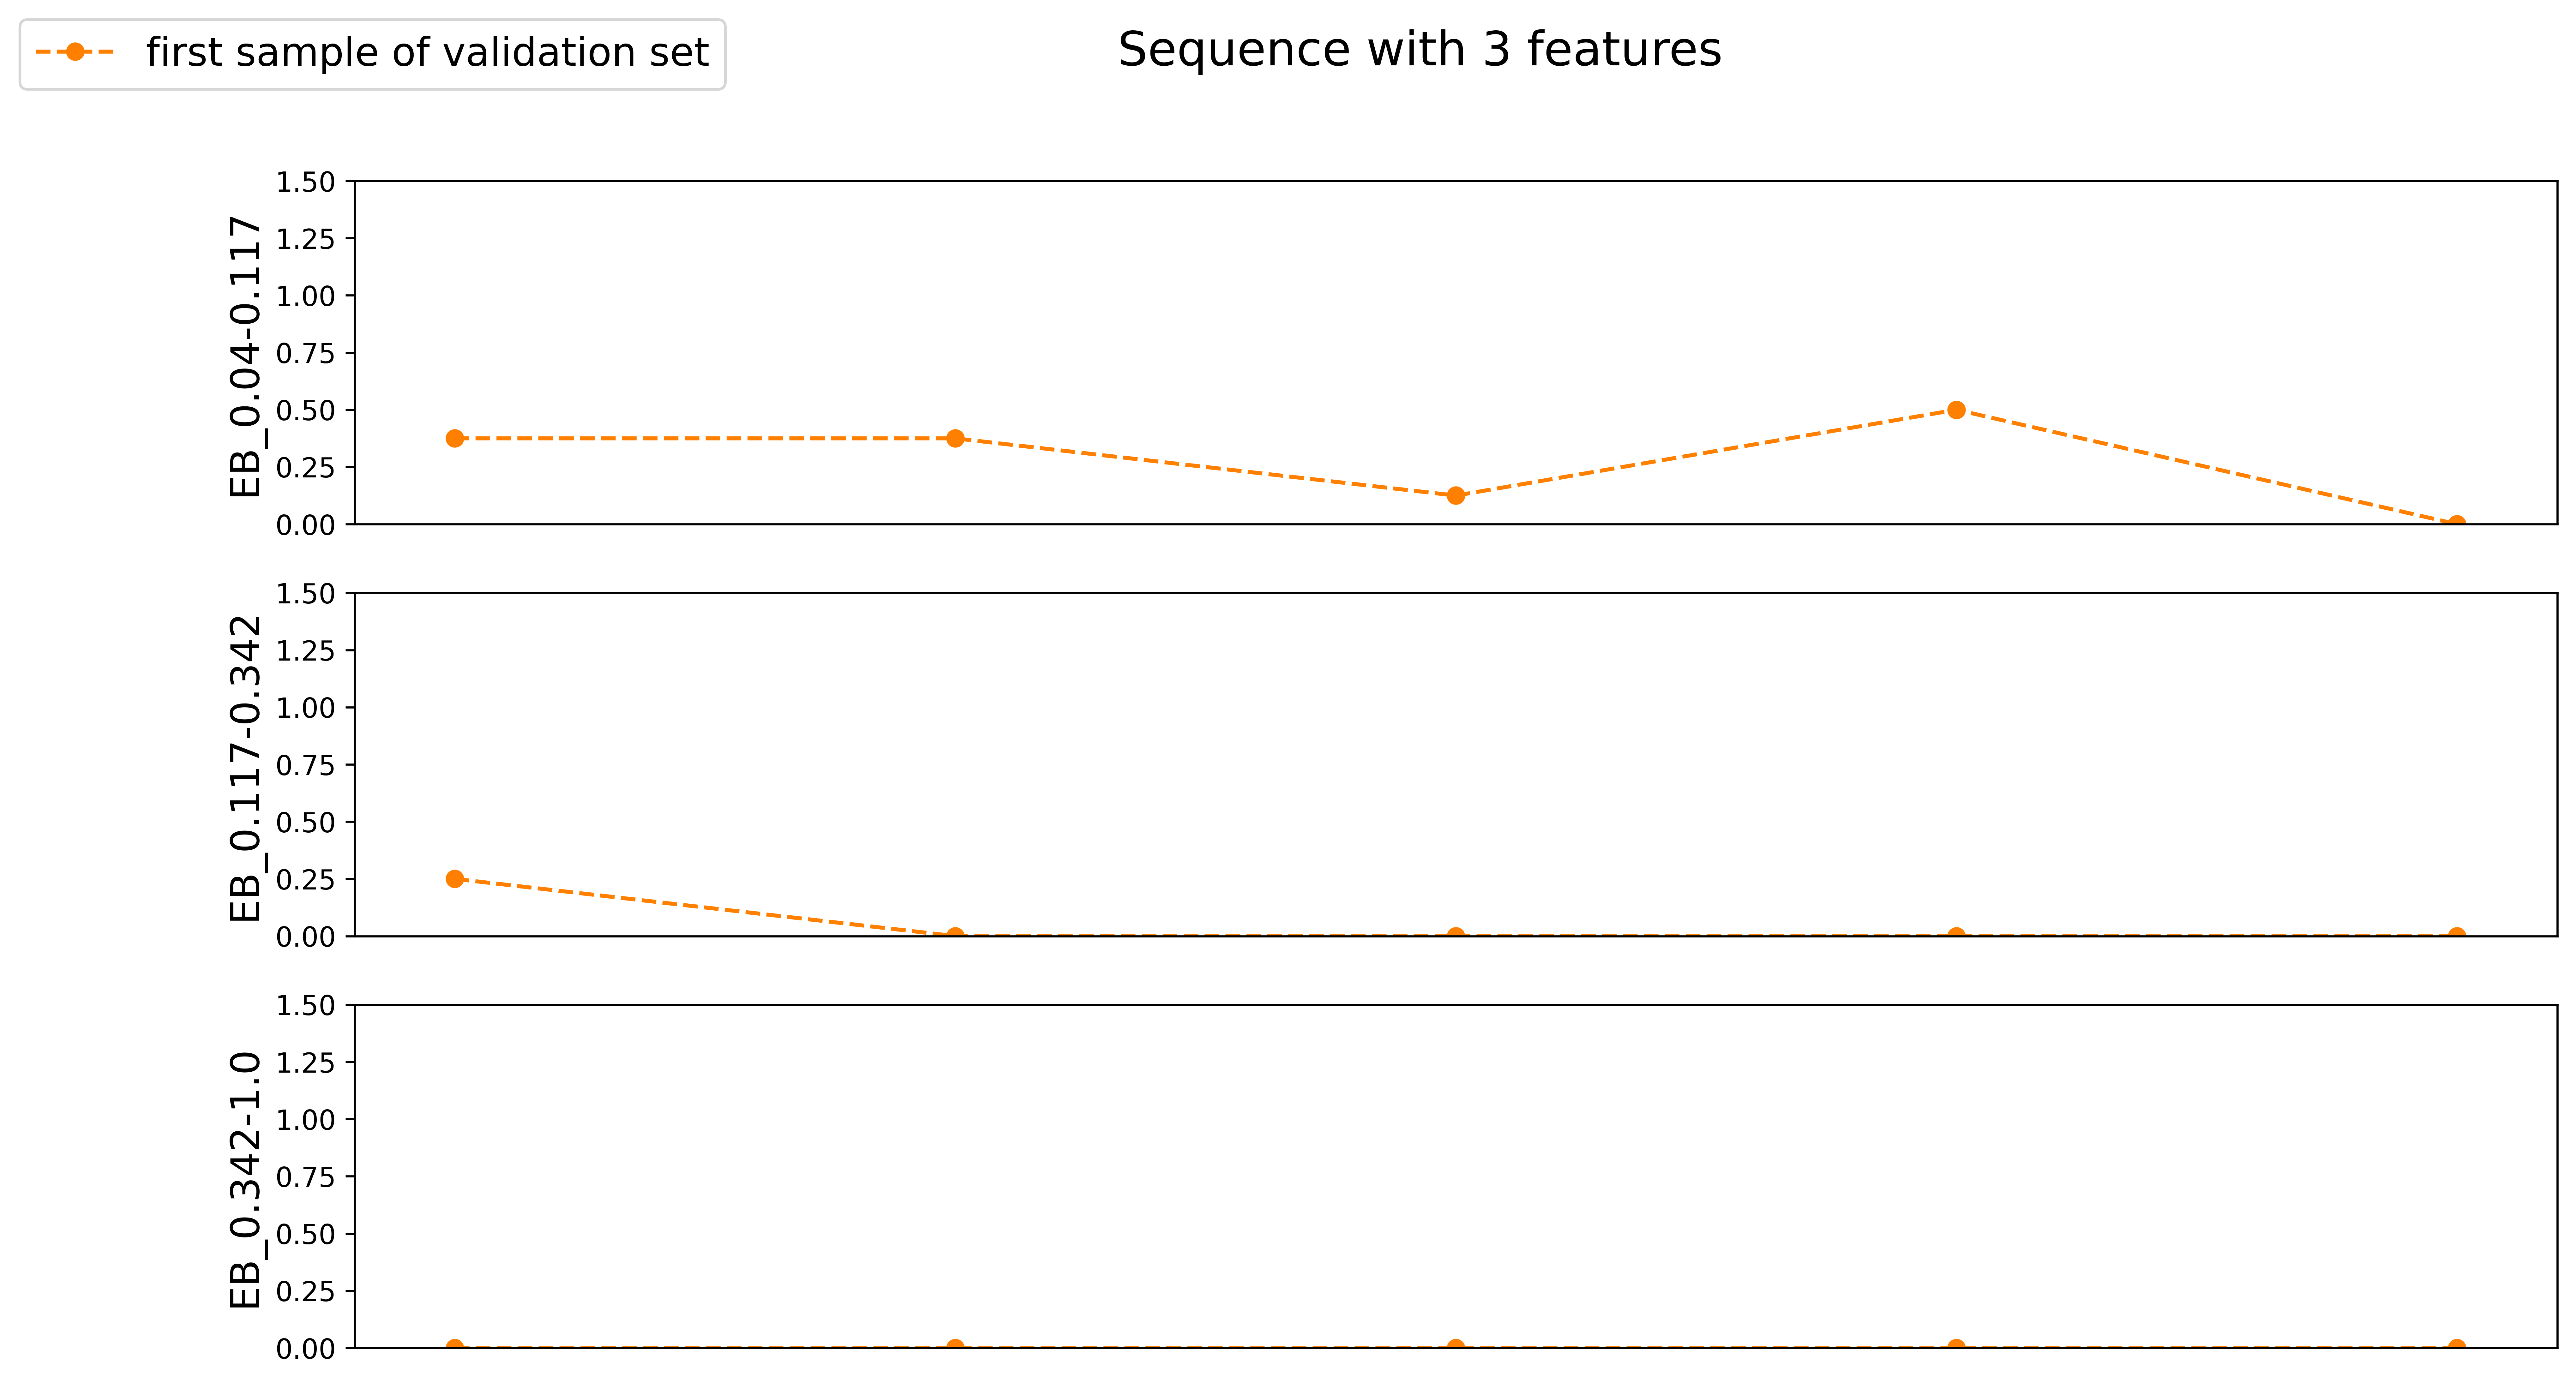

In [15]:
features_names = ["EB_"+fn.split("_")[1] for fn in ds.getFeaturesColsNames()]
plot_sequences(np.expand_dims(val_x[0], axis=0), scaled=True, labels=["first sample of validation set"], features_names=features_names, showFig=True, saveFig=False)

In [ ]:
model_names = [model_name for model_name in model_names if "lstm" in model_name]
model_names = ["AnomalyDetector_cnn_l2_u32", "AnomalyDetector_rnn_l2_u32", "AnomalyDetector_lstm_l2_u32"]

In [ ]:
timesteps = train_x[0].shape[0]
nfeatures = train_x[0].shape[1]
batch_size = 20

outDirRoot = Path("./").parent.resolve().joinpath(f"run_{strftime('%Y%m%d-%H%M%S')}")

for model_name in model_names:
    
    print(f"\n\n\n********************* {model_name} training *********************\n\n")
    outDirBase = outDirRoot.joinpath(f"model_{model_name}_dataset_{dataset_id}_tsl_{tsl}")
    outDirBase.mkdir(parents=True, exist_ok=True)
    ds.store_scaler(outDirBase)
    ds.dumpDatasetParams("json", outDirBase)
    
    # Callbacks 
    clc = CustomLogCallback(
            [1, 5, 10, 50, 100 ,200],
            validation_data=(val_x, val_y), 
            out_dir_root=outDirBase, 
            wandb_run=None, 
            metadata={"dataset_id": dataset_id, "model": model_name, "training": "heavy"}
    )
    ea = EarlyStopping(monitor="val_loss", patience=10, mode="min")
    callbacks = [
        ea, clc
    ]
    
    anomalyDetector = AnomalyDetectorBuilder.getAnomalyDetector(model_name, timesteps, nfeatures)
    anomalyDetector.model.compile(optimizer='adam', loss=CustomMSE(nfeatures, output_dir=outDirBase)) # 
    anomalyDetector.model.summary()
    anomalyDetector.store_parameters(outDirBase)

    #history = anomalyDetector.model.fit(train_x, train_x, verbose=0, epochs=200, batch_size=20, validation_data=(val_x, val_x), callbacks=callbacks)
    #clc.on_epoch_end(None, force=True)
    #loss_plot(history.history["loss"], history.history["val_loss"], model_name=model_name, title=f"Training loss", outputDir=outDirBase, figName="train_val_loss.png", showFig=False)